* [github](https://github.com/mchong6/JoJoGAN), [colab](https://colab.research.google.com/github/mchong6/JoJoGAN/blob/main/stylize.ipynb#scrollTo=AgfLsIELgsLq), [huggingface](https://huggingface.co/spaces/akhaliq/JoJoGAN)

In [4]:
import PIL.Image

In [5]:
PIL.Image

<module 'PIL.Image' from '/usr/lib/python3/dist-packages/PIL/Image.py'>

In [ ]:
!pip install tqdm gdown scipy lpips dlib opencv-python

In [2]:
!git clone https://github.com/mchong6/JoJoGAN.git && mkdir JoJoGAN/models

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2 && rm shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat JoJoGAN/models/dlibshape_predictor_68_face_landmarks.dat

In [ ]:
!gdown --id 1a0QDEHwXQ6hE_FcYEyNMuv5r5UnRQLKT -O JoJoGAN/models/art.pt
!gdown --id 1o6ijA3PkcewZvwJJ73dJ0fxhndn0nnh7 -O JoJoGAN/models/e4e_ffhq_encode.pt
!gdown --id 1Bnh02DjfvN_Wm8c4JdOiNV4q9J7Z_tsi -O JoJoGAN/models/disney_preserve_color.pt

In [35]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [6]:
%cd JoJoGAN
import util
import model
import e4e_projection

/content/JoJoGAN


In [13]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((1024, 1024)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [14]:
generator_art = model.Generator(1024, 512, 8, 2).to('cpu')
ckpt_art = torch.load('models/art.pt', map_location=lambda storage, loc: storage)
generator_art.load_state_dict(ckpt_art["g"], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['conv1.conv.update', 'to_rgb1.conv.update', 'convs.0.conv.update', 'convs.1.conv.update', 'convs.2.conv.update', 'convs.3.conv.update', 'convs.4.conv.update', 'convs.5.conv.update', 'convs.6.conv.update', 'convs.7.conv.update', 'convs.8.conv.update', 'convs.9.conv.update', 'convs.10.conv.update', 'convs.11.conv.update', 'convs.12.conv.update', 'convs.13.conv.update', 'convs.14.conv.update', 'convs.15.conv.update', 'to_rgbs.0.conv.update', 'to_rgbs.1.conv.update', 'to_rgbs.2.conv.update', 'to_rgbs.3.conv.update', 'to_rgbs.4.conv.update', 'to_rgbs.5.conv.update', 'to_rgbs.6.conv.update', 'to_rgbs.7.conv.update'])

In [15]:
generator_disney = model.Generator(1024, 512, 8, 2).to('cpu')
ckpt_disney = torch.load('models/disney_preserve_color.pt', map_location=lambda storage, loc: storage)
generator_disney.load_state_dict(ckpt_disney["g"], strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['conv1.conv.update', 'to_rgb1.conv.update', 'convs.0.conv.update', 'convs.1.conv.update', 'convs.2.conv.update', 'convs.3.conv.update', 'convs.4.conv.update', 'convs.5.conv.update', 'convs.6.conv.update', 'convs.7.conv.update', 'convs.8.conv.update', 'convs.9.conv.update', 'convs.10.conv.update', 'convs.11.conv.update', 'convs.12.conv.update', 'convs.13.conv.update', 'convs.14.conv.update', 'convs.15.conv.update', 'to_rgbs.0.conv.update', 'to_rgbs.1.conv.update', 'to_rgbs.2.conv.update', 'to_rgbs.3.conv.update', 'to_rgbs.4.conv.update', 'to_rgbs.5.conv.update', 'to_rgbs.6.conv.update', 'to_rgbs.7.conv.update'])

Loading e4e over the pSp framework from checkpoint: models/e4e_ffhq_encode.pt


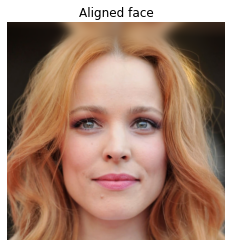

In [39]:
%matplotlib inline
aligned_face = util.align_face('test_input/4.jpg')
my_w =  e4e_projection.projection(aligned_face, 'test_input/m.pt', 'cpu').unsqueeze(0)
util.display_image(aligned_face, title='Aligned face')

In [40]:
generator_art.eval()
generator_disney.eval()
torch.manual_seed(3000)
torch.set_grad_enabled(False)
art_sample = generator_art(my_w, input_is_latent=True)
disney_sample = generator_disney(my_w, input_is_latent=True)

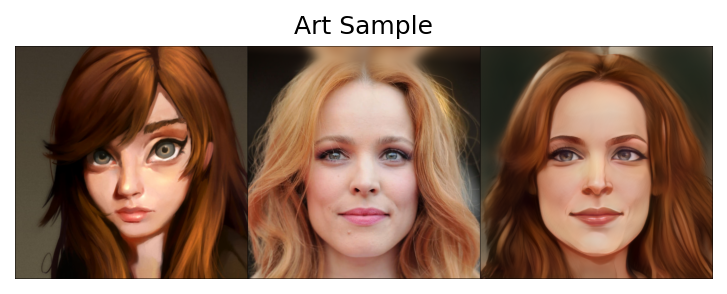

In [41]:
plt.rcParams['figure.dpi'] = 150
art_style_path = 'style_images_aligned/art.png'
art_style_image = transform(util.Image.open(art_style_path)).unsqueeze(0).to('cpu')
face = transform(aligned_face).unsqueeze(0).to('cpu')
my_output = torch.cat([art_style_image, face, art_sample], 0)
util.display_image(torchvision.utils.make_grid(my_output, normalize=True, value_range=(-1, 1)), title='Art Sample')

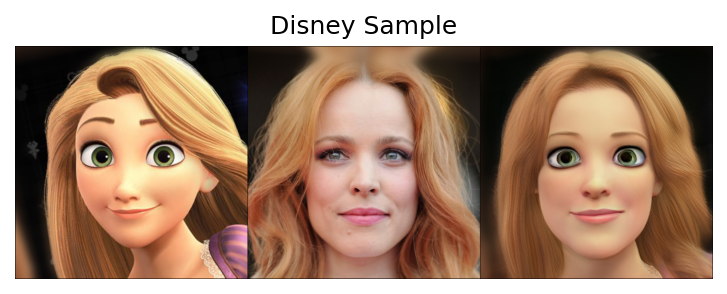

In [42]:
plt.rcParams['figure.dpi'] = 150
disney_style_path = 'style_images_aligned/disney.png'
disney_style_image = transform(util.Image.open(disney_style_path)).unsqueeze(0).to('cpu')
face = transform(aligned_face).unsqueeze(0).to('cpu')
my_output = torch.cat([disney_style_image, face, disney_sample], 0)
util.display_image(torchvision.utils.make_grid(my_output, normalize=True, value_range=(-1, 1)), title='Disney Sample')